# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line

import time

#Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cells/
  inflating: __MACOSX/data/._cells   
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/cells/.DS_Store    
  inflating: __MACOSX/data/cells/._.DS_Store  
   creating: data/cells/scans/
  inflating: __MACOSX/data/cells/._scans  
   creating: data/cells/labels/
  inflating: __MACOSX/data/cells/._labels  
  inflating: data/cells/scans/BMMC_16.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_16.bmp  
  inflating: data/cells/scans/BMMC_17.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_17.bmp  
  inflating: data/cells/scans/BMMC_15.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_15.bmp  
  inflating: data/cells/scans/BMMC_14.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_14.bmp  
  inflating: data/cells/scans/BMMC_28.bmp  
  inflating: __MACOSX/data/cells/scans/._BMMC_28.bmp  
  inflating: data/cells/scans/BMMC_10.bmp  
  inflat

#Defining the Dataset Class

In [3]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    self.data_dir = data_dir
    self.images_dir = os.path.join(self.data_dir,'scans')
    self.masks_dir = os.path.join(self.data_dir,'labels')
    self.file_names = os.listdir(self.images_dir)
    self.images_data = [os.path.join(self.images_dir, i) for i in self.file_names]
    self.masks_data = [os.path.join(self.masks_dir, i) for i in self.file_names]

    self.size = size
    self.train = train
    self.train_test_split = train_test_split
    self.augment_data = augment_data
    if self.train == True:
      self.images = self.images_data[:round(self.train_test_split*len(self.file_names))] #38*0.8=30.4
      self.masks = self.masks_data[:round(self.train_test_split*len(self.file_names))]
    if self.train == False:
      self.images = self.images_data[round(self.train_test_split*len(self.file_names)):]
      self.masks = self.masks_data[round(self.train_test_split*len(self.file_names)):]

  def __getitem__(self, idx):
      #load image and mask from index idx of your data
      image = Image.open(self.images[idx])
      mask = Image.open(self.masks[idx])

      image_p = transforms.Compose([transforms.ToTensor(),transforms.Resize(self.size)])
      image = image_p(image)
      image = image
      
      mask_n = np.asarray(mask)
      mask_t = torch.from_numpy(mask_n).unsqueeze(0)
      mask_p = transforms.Resize(self.size)
      mask = mask_p(mask_t)
     
      #data augmentation part
      if self.augment_data:
        augment_mode = np.random.randint(0, 4)
        if augment_mode == 0:
          #flip image vertically
          flip_v = transforms.RandomVerticalFlip(p=1)
          image = flip_v(image)
          mask = flip_v(mask)
        elif augment_mode == 1:
          #flip image horizontally
          flip_h = transforms.RandomHorizontalFlip(p=1)
          image = flip_h(image)
          mask = flip_h(mask)
        elif augment_mode == 2:
          #apply gamma correction
          random_gamma = np.random.randint(1, 3)
          image = TF.adjust_gamma(image,random_gamma)
        else:
          #rotate image
          rotation = transforms.RandomRotation(degrees=180)
          image = rotation(image)
          mask = rotation(mask)

      return image, mask    

  def __len__(self):
    return len(self.images)


In [ ]:
#input image-mask size
image_size = 128
#root directory of project
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data/cells')

trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = 4, shuffle=True, drop_last = True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = 4)

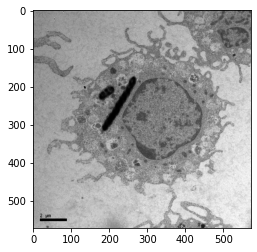

In [ ]:
# np.set_printoptions(threshold=np.inf)
a, b= trainset.__getitem__(4)
a = a.squeeze(0).cpu().numpy()
plt.imshow(a,cmap='gray')
plt.show()

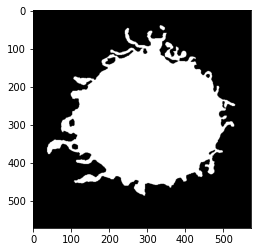

In [ ]:
b = b.squeeze(0).cpu().numpy()
plt.imshow(b,cmap='gray')
plt.show()

In [ ]:
for i, data in enumerate(trainloader):
  image, label = data
  print(i, label.shape)

0 torch.Size([4, 1, 128, 128])
1 torch.Size([4, 1, 128, 128])
2 torch.Size([4, 1, 128, 128])
3 torch.Size([4, 1, 128, 128])
4 torch.Size([4, 1, 128, 128])
5 torch.Size([4, 1, 128, 128])
6 torch.Size([4, 1, 128, 128])


In [ ]:
for i, data in enumerate(testloader):
  image, label = data
  print(i, image.shape, label.shape)

0 torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])
1 torch.Size([4, 1, 128, 128]) torch.Size([4, 1, 128, 128])


#Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [4]:
class twoConvBlock(nn.Module):
  def __init__(self, in_c, out_c):
    super(twoConvBlock, self).__init__()
    self.twoConvs = nn.Sequential(
        nn.Conv2d(in_c,out_c,3),
        nn.ReLU(),
        nn.Conv2d(out_c,out_c,3),
        nn.BatchNorm2d(out_c),
        nn.ReLU()
    )

  def forward(self, x):
    x = self.twoConvs(x)
    return x

class downStep(nn.Module):
  def __init__(self, in_c, out_c, with_p = True):
    super(downStep, self).__init__()
    self.with_p = with_p
    self.two_convs = twoConvBlock(in_c,out_c)
    self.pool = nn.MaxPool2d(2,stride=2)

  def forward(self,x):
    if self.with_p == True:
      x = self.pool(x)
    else:
      x = x
    x = self.two_convs(x)
    return x


class upStep(nn.Module):
  def __init__(self, in_c, out_c):
    super(upStep, self).__init__()
    self.up_convs = nn.ConvTranspose2d(in_c,out_c,2,stride=2)
    self.two_convs = twoConvBlock(in_c,out_c)

  def forward(self, x, skip):
    x = self.up_convs(x)
    crop_sh = (skip.shape[2] - x.shape[2]) // 2
    crop_sw = (skip.shape[3] - x.shape[3]) // 2
    skip_crop = skip[:,:,crop_sh:skip.shape[2]-crop_sh,crop_sw:skip.shape[3]-crop_sw]
    x = torch.cat((x,skip_crop),dim=1)
    x = self.two_convs(x)
    return x

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    # Contracting Path
    self.down1 = downStep(1,64,with_p = False)
    self.down2 = downStep(64,128)
    self.down3 = downStep(128,256)
    self.down4 = downStep(256,512)
    
    self.b = downStep(512,1024)

    # Expansive Path
    self.up1 = upStep(1024,512)
    self.up2 = upStep(512,256)
    self.up3 = upStep(256,128)
    self.up4 = upStep(128,64)

    self.c = nn.Conv2d(64,2,1)
    
  def forward(self, x):
    d1 = self.down1(x)
    d2 = self.down2(d1)
    d3 = self.down3(d2)
    d4 = self.down4(d3)

    b = self.b(d4)

    up1 = self.up1(b,d4)
    up2 = self.up2(up1,d3)
    up3 = self.up3(up2,d2)
    up4 = self.up4(up3,d1)

    out = self.c(up4)

    # print(d1.shape)
    # print(d2.shape)
    # print(d3.shape)
    # print(d4.shape)
    # print(b.shape)
    # print(up1.shape)
    # print(up2.shape)
    # print(up3.shape)
    # print(up4.shape)
    # print(out.shape)

    return out


#Training

batch 0 --- Loss: 0.2085
batch 1 --- Loss: 0.1698
batch 2 --- Loss: 0.1426
batch 3 --- Loss: 0.1868
batch 4 --- Loss: 0.1556
batch 5 --- Loss: 0.1431
batch 6 --- Loss: 0.1371
Epoch 1 / 20 --- Loss: 0.1525
Accuracy: 0.4796 ---- Loss: 0.1739
batch 0 --- Loss: 0.1481
batch 1 --- Loss: 0.1285
batch 2 --- Loss: 0.1670
batch 3 --- Loss: 0.1557
batch 4 --- Loss: 0.2055
batch 5 --- Loss: 0.1712
batch 6 --- Loss: 0.1466
Epoch 2 / 20 --- Loss: 0.1497
Accuracy: 0.5171 ---- Loss: 0.1763
batch 0 --- Loss: 0.1431
batch 1 --- Loss: 0.1441
batch 2 --- Loss: 0.1165
batch 3 --- Loss: 0.1255
batch 4 --- Loss: 0.1538
batch 5 --- Loss: 0.1644
batch 6 --- Loss: 0.1214
Epoch 3 / 20 --- Loss: 0.1292
Accuracy: 0.6071 ---- Loss: 0.1680
batch 0 --- Loss: 0.1527
batch 1 --- Loss: 0.1568
batch 2 --- Loss: 0.1316
batch 3 --- Loss: 0.1524
batch 4 --- Loss: 0.1369
batch 5 --- Loss: 0.1411
batch 6 --- Loss: 0.1556
Epoch 4 / 20 --- Loss: 0.1369
Accuracy: 0.6616 ---- Loss: 0.1622
batch 0 --- Loss: 0.1501
batch 1 --- Los

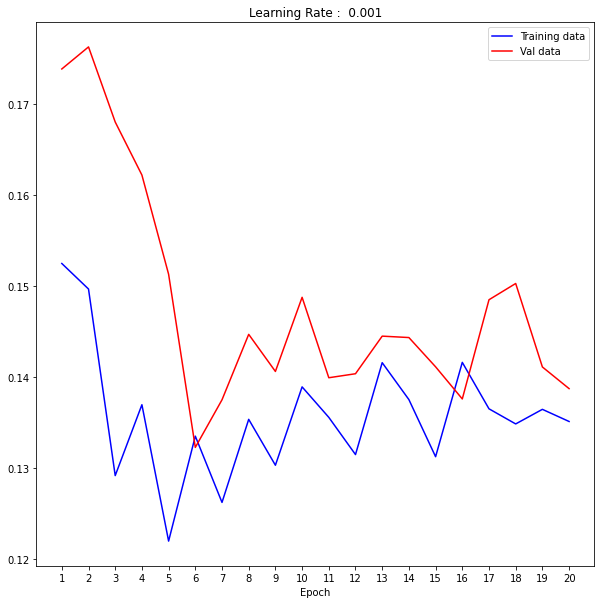

In [8]:
start = time.time()
#Paramteres
#learning rate
lr = 1e-3

#number of training epochs
epoch_n = 20

#input image-mask size
image_size = 572
#316-132
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False, augment_data = False)
testloader = DataLoader(testset, batch_size = batch_size)

# device = torch.device('cuda:0' if gpu else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

train_losses = []
val_losses = []
model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    
    # image = image.unsqueeze(1).to(device)
    # label = label.long().to(device)

    image = image.to(device)
    label = label.squeeze(1).long().to(device)
    pred = model(image)

    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  train_losses.append(epoch_loss / trainset.__len__())
  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      # image = image.unsqueeze(1).to(device)
      # label = label.long().to(device)
      
      image = image.to(device)   
      label = label.squeeze(1).long().to(device)

      pred = model(image)
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
  
  
  val_losses.append(total_loss / testset.__len__())
end = time.time()
print('Training time with lr=' + str(lr)+':  %.4f s'%(end-start))
plt.figure(1,figsize=(10,10))
plt.xticks(np.arange(len(train_losses)),np.arange(1,len(train_losses)+1))
plt.plot(train_losses,'b',label='Training data')
plt.plot(val_losses,'r',label='Val data')
plt.title('Learning Rate :  '+f'{lr}')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Testing and Visualization

In [6]:
model.eval()

input_images = []
output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    # input_image = image.unsqueeze(0).unsqueeze(0).to(device)
    input_image = image.unsqueeze(0).to(device)
    labels = labels.squeeze(0)

    pred = model(input_image)
    # print(torch.max(pred, dim = 1)[1])

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()
    
    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
 
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    image = image.squeeze(0)
    image = image[crop_x: image.shape[0] - crop_x, crop_y: image.shape[1] - crop_y].numpy()

    output_masks.append(output_mask)
    output_labels.append(labels)
    input_images.append(image)


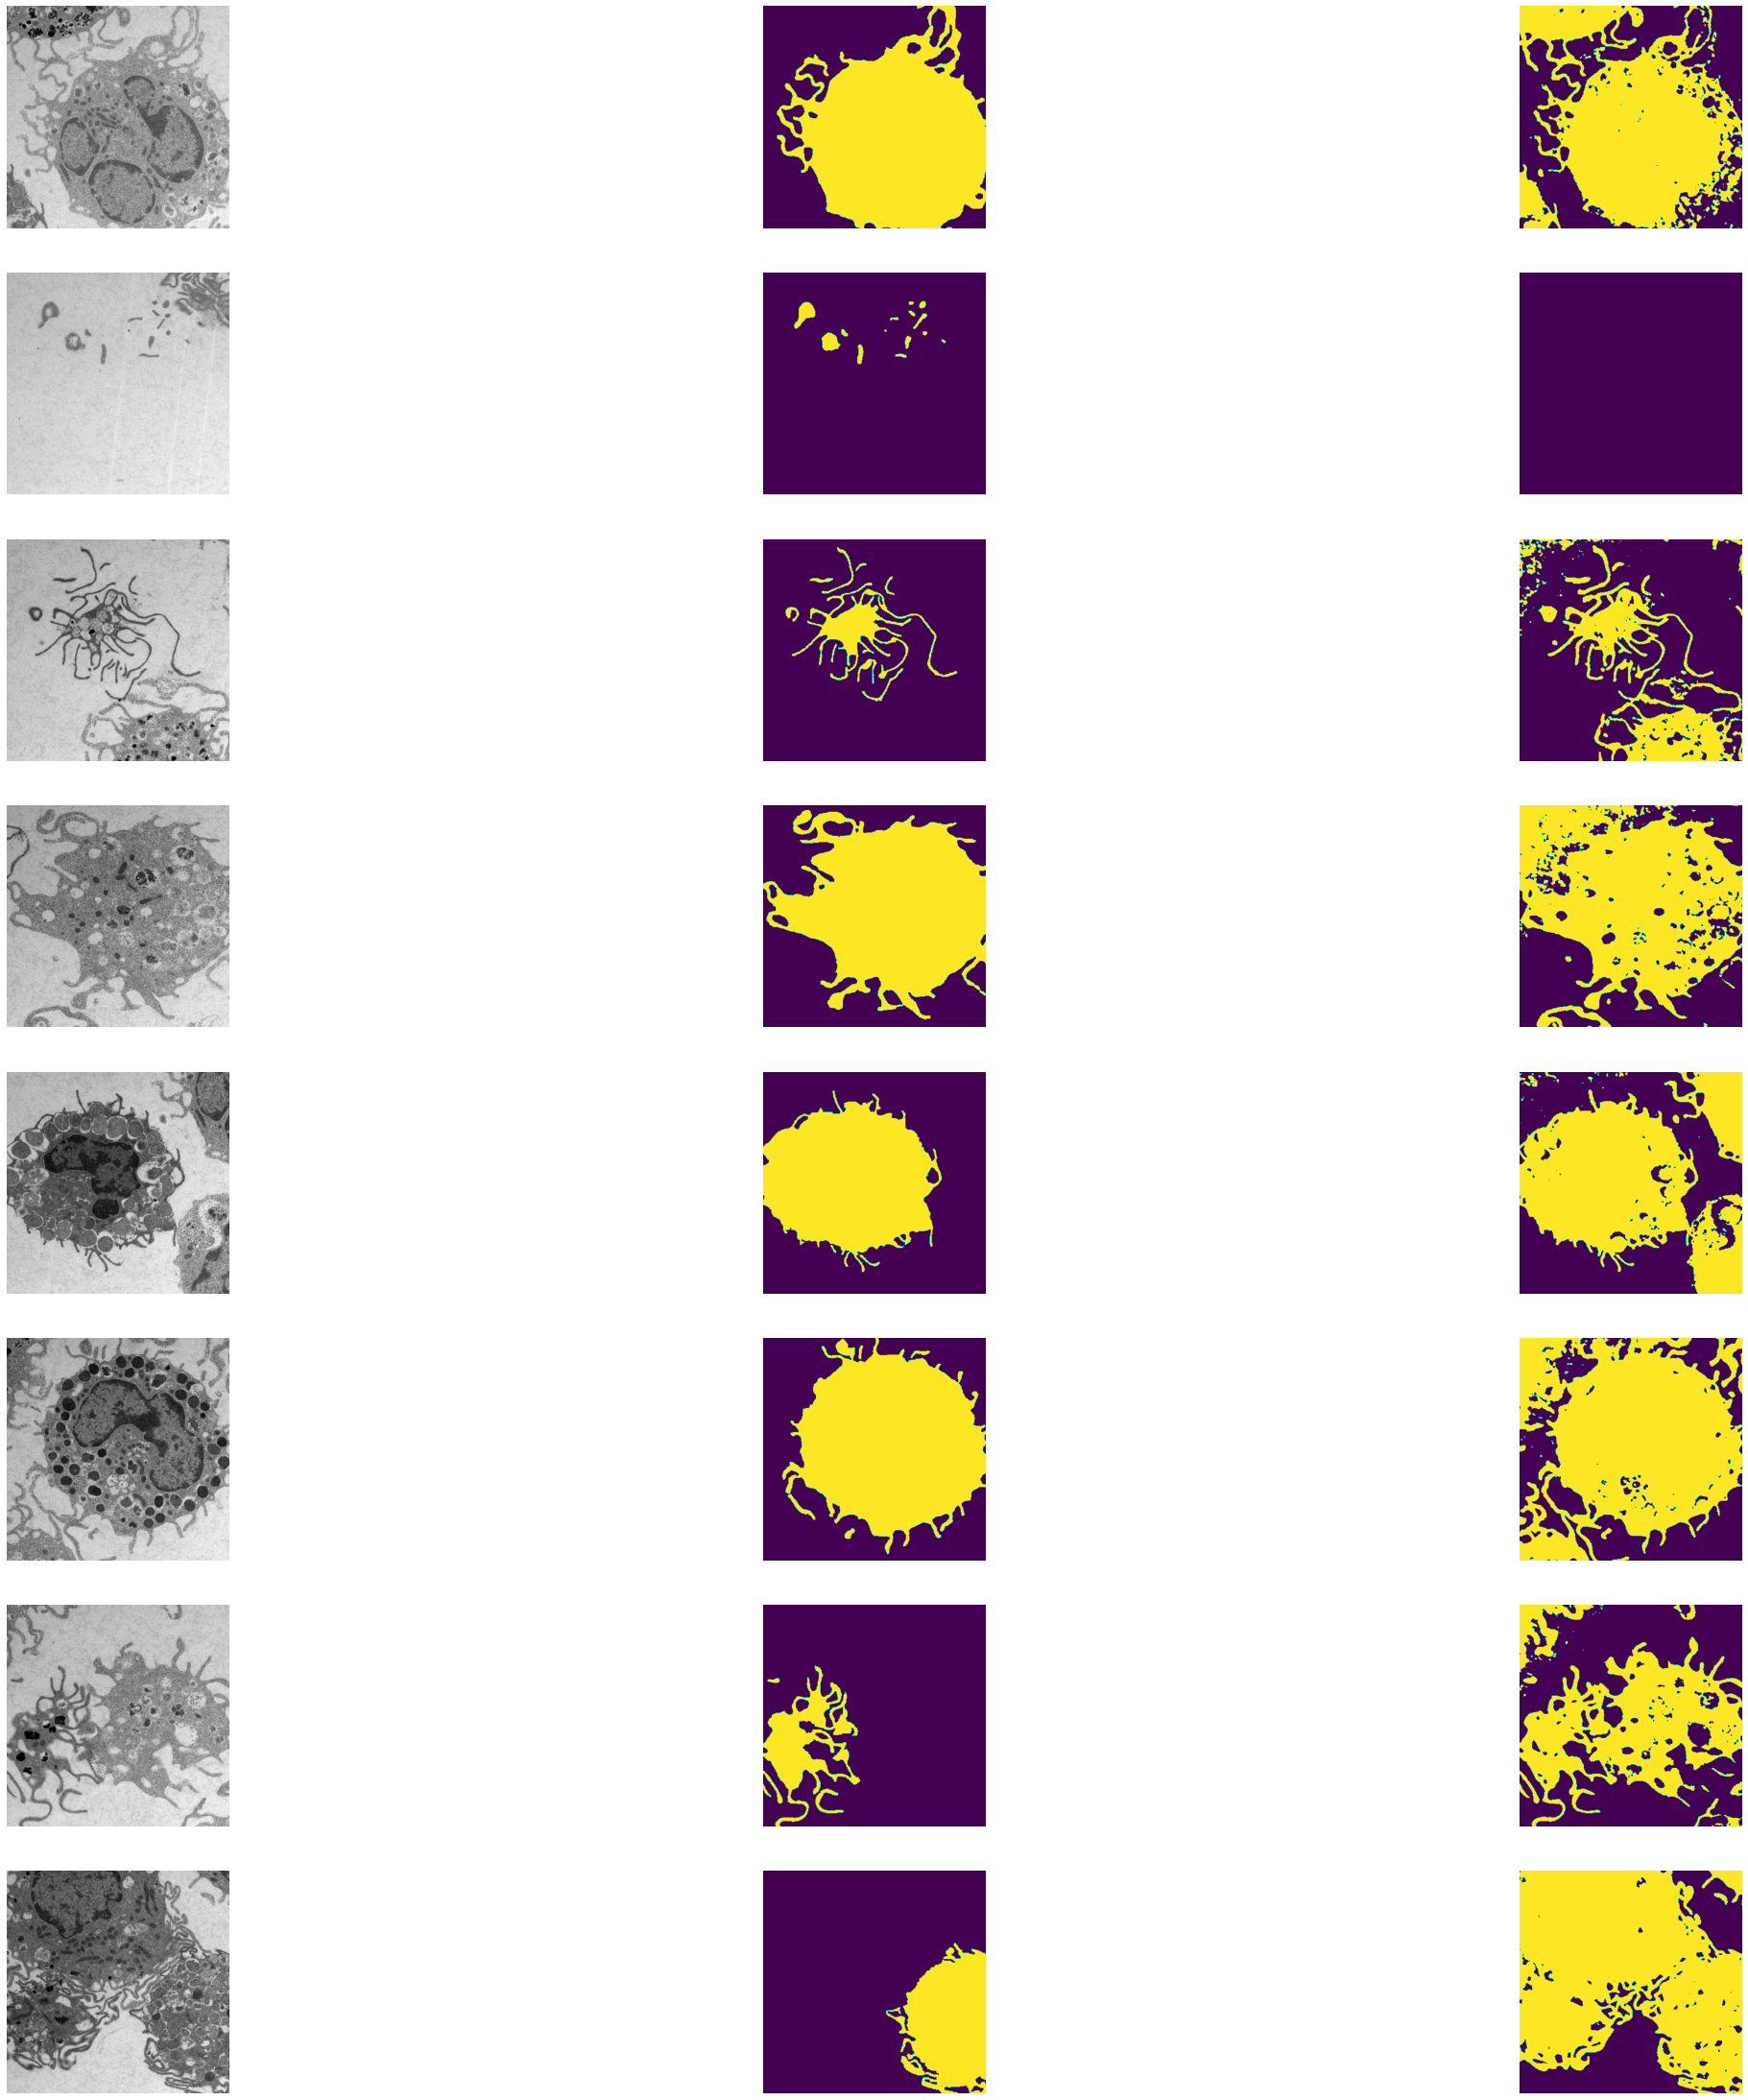

In [ ]:
fig, axes = plt.subplots(testset.__len__(), 3, figsize = (40, 40))
# batch = 4, epoch = 20, lr = 0.001
for i in range(testset.__len__()):
  axes[i, 0].imshow(input_images[i],cmap='gray')
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_labels[i])
  axes[i, 1].axis('off')
  axes[i, 2].imshow(output_masks[i])
  axes[i, 2].axis('off')

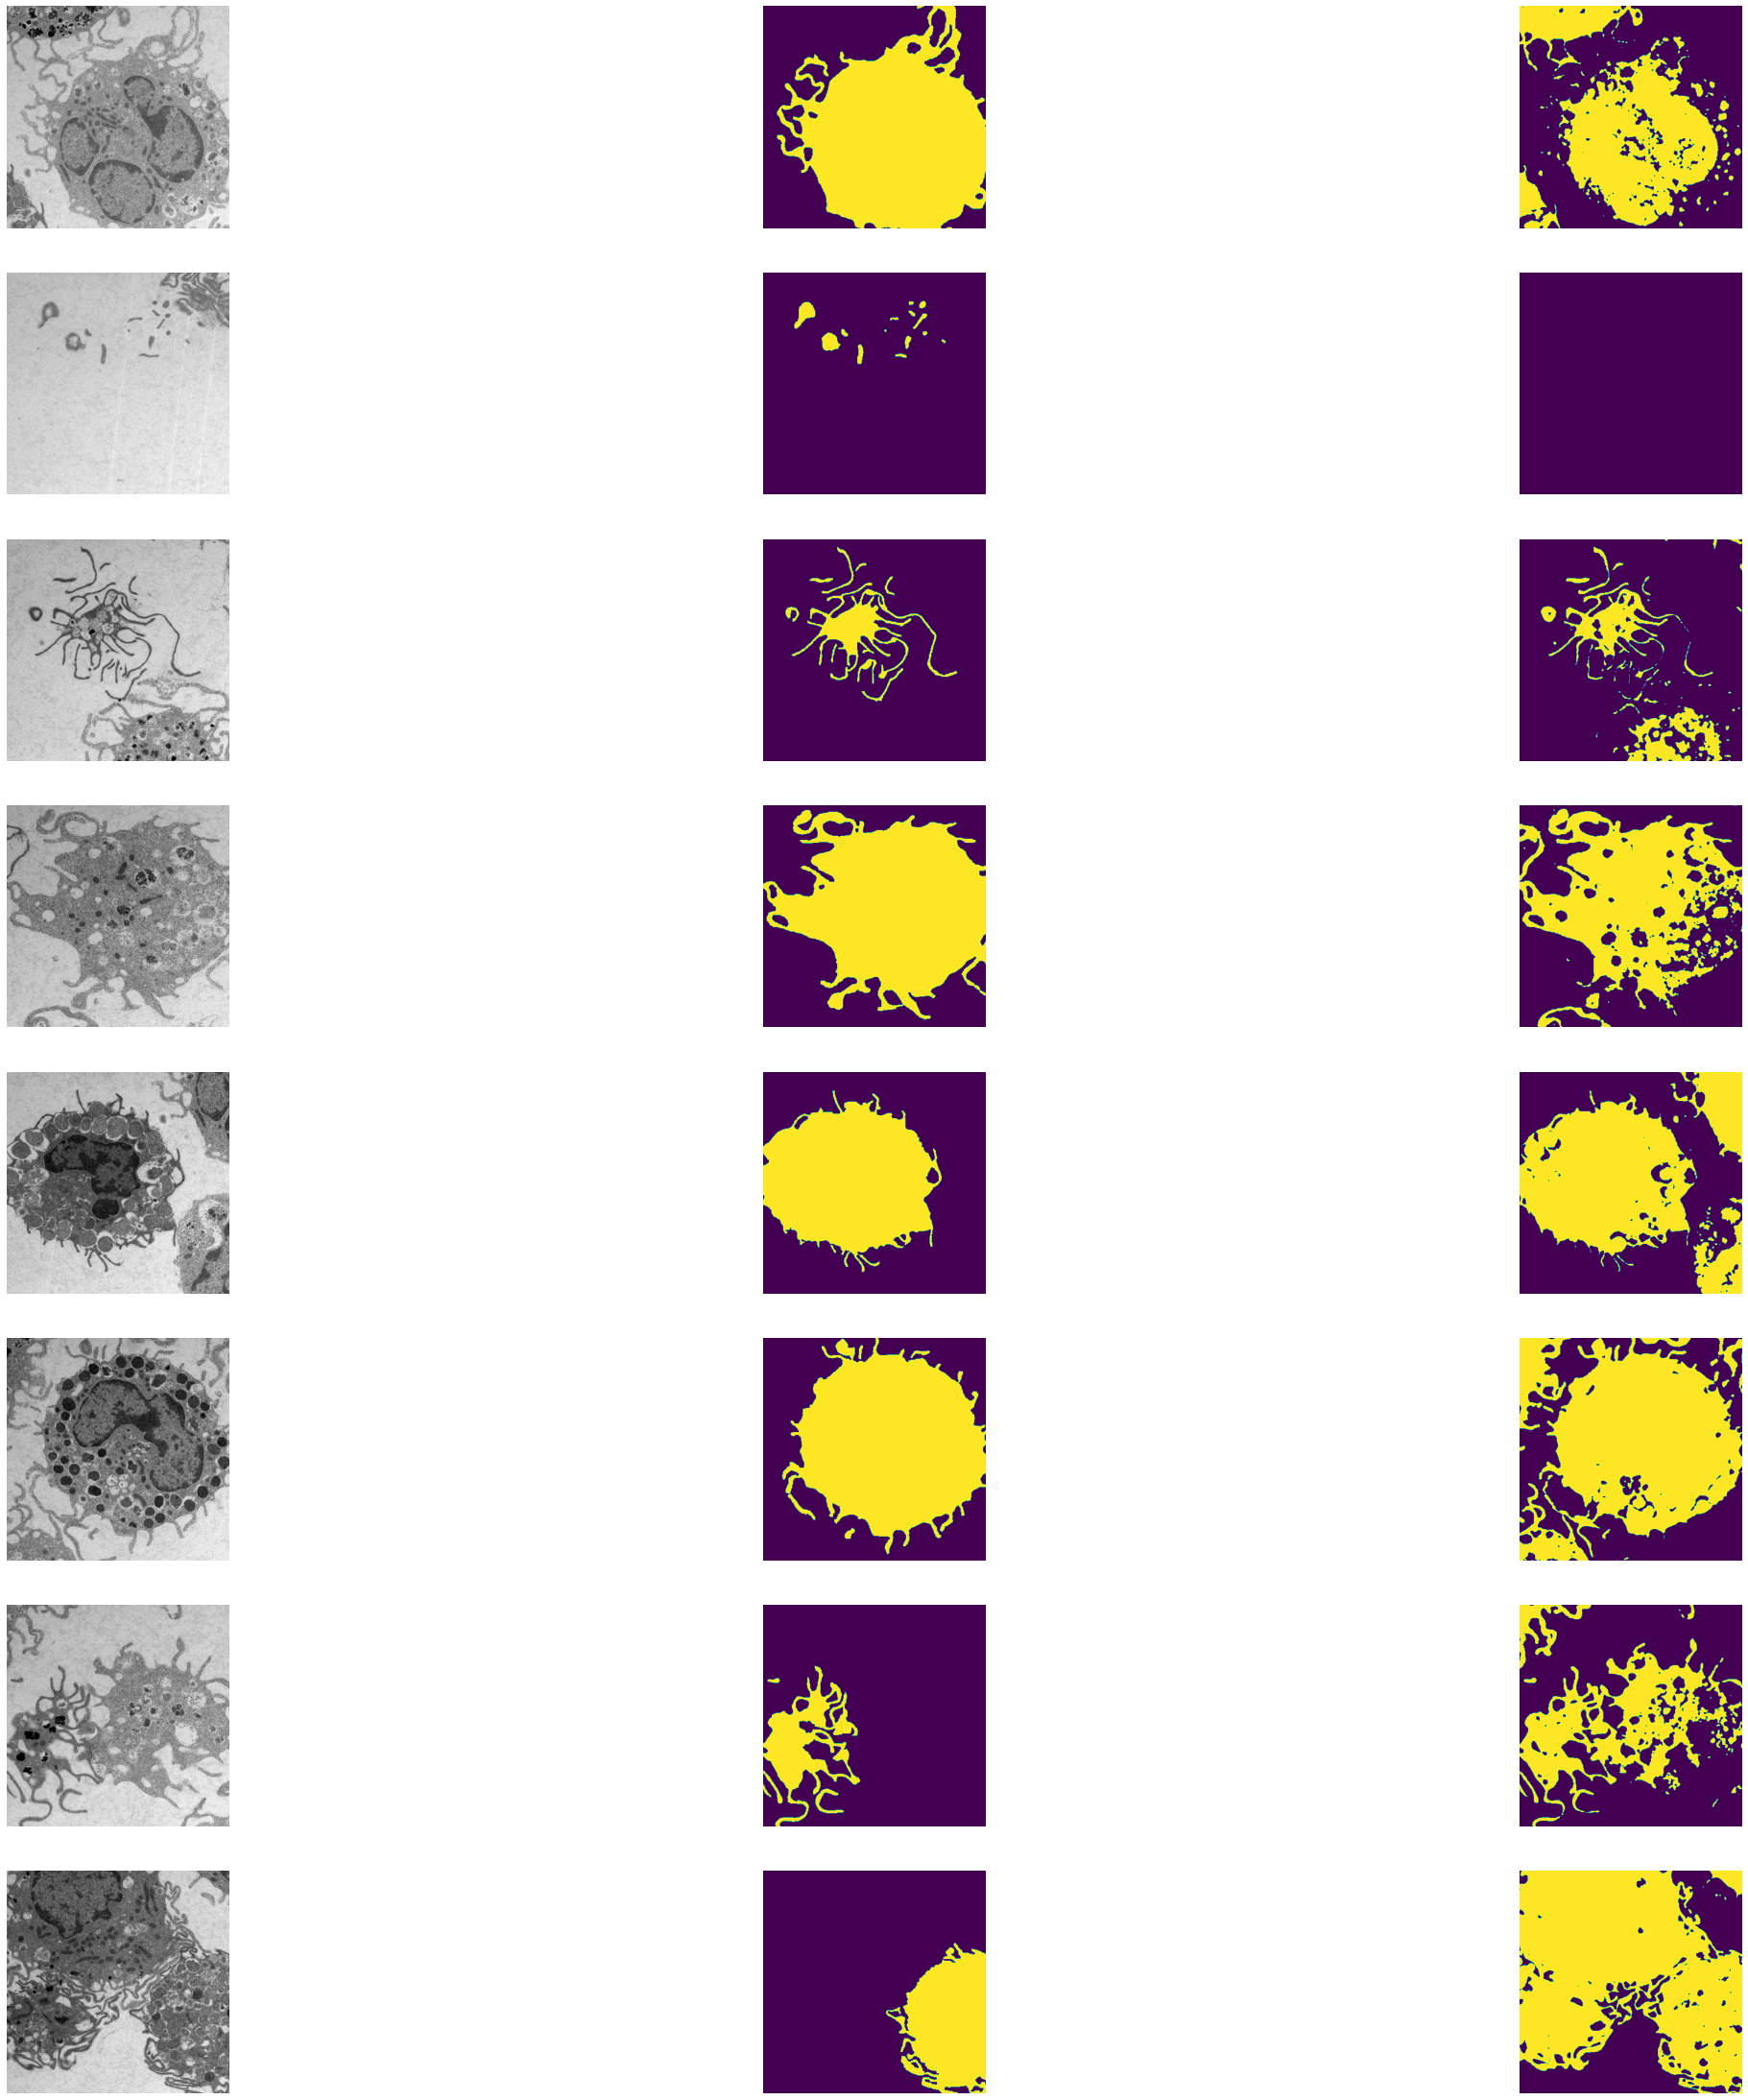

In [ ]:
fig, axes = plt.subplots(testset.__len__(), 3, figsize = (40, 40))
# batch = 8, epoch = 15, lr = 0.001
for i in range(testset.__len__()):
  axes[i, 0].imshow(input_images[i],cmap='gray')
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_labels[i])
  axes[i, 1].axis('off')
  axes[i, 2].imshow(output_masks[i])
  axes[i, 2].axis('off')